# *Transmisión de Calor.*
## Determinación del área de transmisión de calor: flujo en contracorriente


Recuerda las ecuaciones empleadas en el diseño de un cambiador de calor: <br>
$$Q={m}'\cdot {C_p}'\cdot \Delta {T}'$$
$$Q={m}''\cdot {C_p}''\cdot \Delta {T}''$$
$$Q=U\cdot A \cdot \Delta {T}_{ml}$$
donde $Q$ es el caudal de calor, ${m}'$ y ${m}''$ son los caudales másicos de los fluidos caliente y frío, respectivamente, ${C_p}'$ y ${C_p}''$ son los calores específicos de los fluidos caliente y frío, respectivamente, $\Delta {T}'$ y $\Delta {T}''$ son los incrementos de temperatura experimentados por los fluidos caliente y frío, respectivamente, y $\Delta {T}_{ml}$ es el incremento de temperatura media logarítmica. Se supone que no hay pérdidas de calor, de forma que el calor cedido por el fluido caliente es igual al ganado por el frío. </br> 

Para caudales y temperaturas se emplea la notación: 1-Fluido caliente; 2-Fluido frío, subíndice e-valor a la entrada, subíndice s-valor a la salida. De este modo, para flujo en contracorriente:</br>

$m1={m}'$: Caudal másico de fluido caliente (agua)<br>
$m2={m}''$: Caudal másico de fluido frío (agua)<br>
<br>
$T1e={T}'_e$: Temperatura de entrada del fluido caliente <br>
$T1s={T}'_s$: Temperatura de salida del fluido caliente <br>
<br>
$T2e={T}''_e$: Temperatura de entrada del fluido frío <br>
$T2s={T}''_s$: Temperatura de salida del fluido frío 

Recuerda que para flujo en contracorriente el incremento de temperatura media logarítmica se calcula como:

$$\Delta {T}_{ml}=\frac{\left( {T}'_s- {T}''_e \right) - \left( {T}'_e- {T}''_s \right) }{ln \left( \frac{ {T}'_s- {T}''_e }{{T}'_e- {T}''_s }   \right)  }  $$



In [1]:
%matplotlib inline
import numpy as np
from scipy import optimize
from scipy.integrate import ode
import matplotlib.pyplot as mpl
import matplotlib.patches as patches
import random
import math
import pandas as pd
import IPython.core.display as di
from ipywidgets import interact
import notebook
from IPython.display import clear_output, display, HTML, Image,Math, Latex
# from IPython.external import mathjax

def Calculo_incr_Tml(T1e, T1s, T2e,T2s):  # T1e,T1s,T2e,T2s: Temperaturas de entrada(e) y salida(s) de los fluidos caliente(1)
    # y frío(2). Sólo para flujo en contracorriente.

    incr_1 = T1s - T2e
    incr_2 = T1e - T2s
    if incr_1 == incr_2:
        incr_Tml = incr_1
    else:
        incr_Tml = (incr_1 - incr_2) / np.log(incr_1 / incr_2)

    return incr_Tml


def Cp_AguaLiquida(T):

    T_Kelvin=(T+273.15)/1000
    A = -203.6060
    B = 1523.290
    C = -3196.413
    D = 2474.455
    E = 3.855326
    Cp = A + B * T_Kelvin + C * T_Kelvin ** 2. + D * T_Kelvin ** 3. + E / (T_Kelvin ** 2.)  # En J/mol·K
    Cp_Masa = Cp / 18  # En kJ/kg·K
    return Cp_Masa


def generador_parametros():  # generación de parámetros del problema

    m1= random.randint(10., 100.) ; m2= random.randint(10., 100.) # Caudal másico kg/h


    while True:  # Generador T fluido caliente
        T1e = random.uniform(0, 100.)
        T1s = random.uniform(0, 100.)
        if T1e > T1s:
            break

    while True:  # Generador T fluido frío
        T2e = random.uniform(0, 100.)
        T2s = random.uniform(0, 100.)
        if T2e < T2s and T1e>T2s and T1s>T2e:
            break

    U = random.uniform(0.9, 1.5)  # Coeff. Global kW/m2·K



    ValoresInicialesTodos = np.array([10., 10., 50., 25., 25., 40.]) # Valores iniciales para caudales y Ts

    ValoresIniciales = np.array([10])  # Valor inicial para el Área de intercambio

    Area = float()
    incognitas = [Area]
    incognitasNombres = ['Area (m2)']

    variables = [m1, m2, T1e, T1s, T2e, T2s]
    variablesNombres = ['m1 (kg/s)', 'm2 (kg/s)', 'T1e (ºC)', 'T1s (ºC)', 'T2e (ºC)', 'T2s (ºC)']
    variablesConocidas = variables.copy()
    variablesConocidasNombres = variablesNombres.copy()

    variableDesconocida = random.randint(0, len(variables))

    incognitasNombres.append(variablesConocidasNombres[variableDesconocida])
    incognitas.append(variables[variableDesconocida])
    incognitasNombres.append('Q (kW)')

    del variablesConocidas[variableDesconocida]
    del variablesConocidasNombres[variableDesconocida]


    variables.append(U)
    variablesConocidasNombres.append('U (kW/m2·ºC)')

    ValoresIniciales = np.insert(ValoresIniciales, 1, ValoresInicialesTodos[variableDesconocida])
    ValoresIniciales = np.insert(ValoresIniciales, 2, 10)

    m1, m2, T1e, T1s, T2e, T2s,U=variables
    valoresVariables = [m1, m2, T1e, T1s, T2e, T2s,U,variableDesconocida]

    del variables[variableDesconocida]

    valoresVariables=tuple(valoresVariables)

    return variablesConocidasNombres,variables,incognitasNombres,incognitas,ValoresIniciales, variableDesconocida,valoresVariables



def Sistema_Ecuaciones(incognitas, m1, m2, T1e, T1s, T2e, T2s, U, index):

    variables= [m1, m2, T1e, T1s, T2e, T2s, U]
    Area, variables[index],Q = incognitas
    m1, m2, T1e, T1s, T2e, T2s,U=variables

    T1Media=np.average(np.array([T1e, T1s]))
    T2Media = np.average(np.array([T2e, T2s]))

    Cp1=Cp_AguaLiquida(T1Media)
    Cp2 = Cp_AguaLiquida(T2Media)


    incr_Tfrio = T2s - T2e
    incr_Tcaliente = T1e - T1s
    incr_Tml = Calculo_incr_Tml(T1e, T1s, T2e, T2s)

    values=[Q-m1 * Cp1 * incr_Tcaliente]  # Ec. 1
    values.append(Q - m2 * Cp2 * incr_Tfrio)  # Ec. 2
    values.append(Q - U * Area * incr_Tml)  # Ec. 1

    return values




display(HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Mostrar código')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Esconder código')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Mostrar código"></form>'''))

#display(HTML('<h1 style="color:#C30"><strong>Avanzar para generar datos</strong></h1>'))

In [2]:
display(HTML('<h1 style="color:#000000"><strong>Los datos del problema son:</strong></h1>'))

variablesConocidasNombres,variables,incognitasNombres,incognitas,ValoresIniciales, variableDesconocida,valoresVariables= generador_parametros() 
m1, m2, T1e, T1s, T2e, T2s, U, index=valoresVariables

ValoresMostrados=[]

for i in range(len(variables)):
    if variableDesconocida>1:
        if i>1 and i<(len(variables)-1):
            ValoresMostrados.append(np.round(variables[i],1))
        elif i==(len(variables)-1):
                 ValoresMostrados.append(np.round(variables[i],3))
        else:
            ValoresMostrados.append(variables[i])
    else:
        if i>0 and i<(len(variables)-1):
            ValoresMostrados.append(np.round(variables[i],1))
        elif i==(len(variables)-1):
                 ValoresMostrados.append(np.round(variables[i],3))
        else:
            ValoresMostrados.append(variables[i])

data = dict(zip(variablesConocidasNombres, ValoresMostrados))

values = pd.DataFrame(data,index=['Datos'], columns=variablesConocidasNombres)


display(values)


display(HTML('<h1 style="color:#000000"><strong>Las incognitas del problema son:</strong></h1>'))

titulos=['Incognita 1', 'Incognita 2','Incognita 3' ]


data1 = dict(zip(titulos,incognitasNombres))

values1 = pd.DataFrame(data1,index=[' '], columns=titulos)


display(values1)



,m1 (kg/s),m2 (kg/s),T1e (ºC),T1s (ºC),T2s (ºC),U (kW/m2·ºC)
Datos,67,31,49.8,41.7,36.2,1.182


,Incognita 1,Incognita 2,Incognita 3
,Area (m2),T2e (ºC),Q (kW)


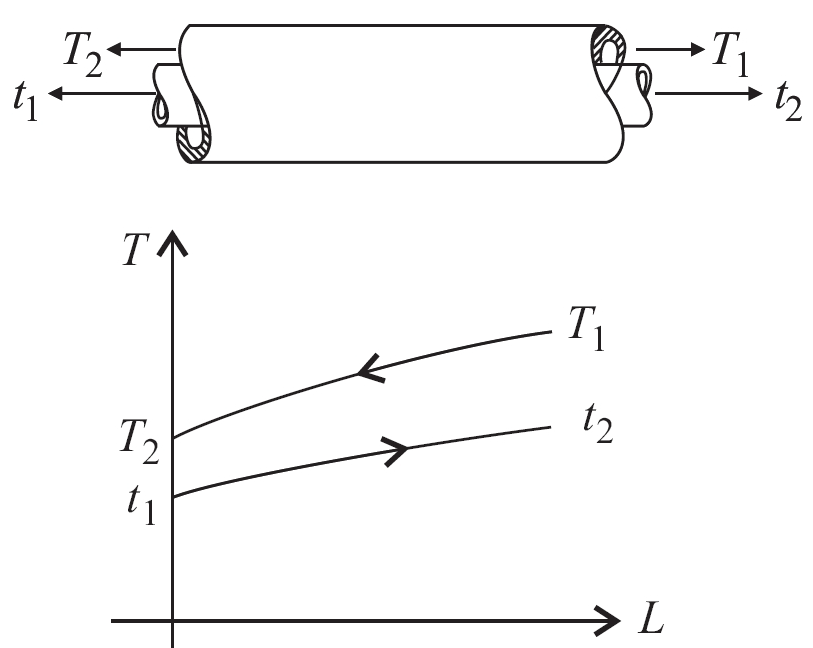

In [3]:
display(HTML('<h1 style="color:#000000"><strong>Esquema del cambiador de calor y perfiles de temperatura.</strong></h1>' ))
display(Image(filename='./Imagenes/Flujo en contracorriente.png',height="400" ,width="400"));

In [4]:
display(HTML('<h1 style="color:#000000"><strong>Los parámetros calculados para la resolución son:</strong></h1>' ))

Resultado = optimize.fsolve(Sistema_Ecuaciones, ValoresIniciales,args=valoresVariables, xtol=1e-06, maxfev=500)

Area,valorVariableDesconocida,Calor=Resultado

ValoresMostrar=[m1, m2, T1e, T1s, T2e, T2s]
ValoresMostrar[variableDesconocida]=valorVariableDesconocida
m1, m2, T1e, T1s, T2e, T2s=ValoresMostrar


incr_Tml=Calculo_incr_Tml(T1e, T1s, T2e,T2s)
T1Media=(T1e+T1s)/2
T2Media = (T2e+T2s)/2
Cp1=Cp_AguaLiquida(T1Media)
Cp2 = Cp_AguaLiquida(T2Media)
parametrosValores=[np.round(Cp1,3),np.round(Cp2,3),np.round(incr_Tml,2)]

    
valores_resultado=[int(np.round(Area))]

if variableDesconocida<=1:
    valores_resultado.append(int(np.round(valorVariableDesconocida)))
else:
    valores_resultado.append(float(np.round(valorVariableDesconocida,1)))
                                   
valores_resultado.append(int(np.round(Calor)))                              


parametrosNombres=['Cp1 (kJ/kg·ºC)','Cp2 (kJ/kg·ºC)','Incr. Temp. Media log. (ºC)']

data_parametros = dict(zip(parametrosNombres,parametrosValores))
values_parametros = pd.DataFrame(data_parametros ,index=['Parámetros'], columns=parametrosNombres)
display(values_parametros )



display(HTML('<h1 style="color:#000000"><strong>El resultado de las corrientes del sistema y del área del intercambiador es:</strong></h1>' ))

data_resultado = dict(zip(incognitasNombres,valores_resultado))
values_resultado = pd.DataFrame(data_resultado ,index=['Resultados'], columns=incognitasNombres)
display(values_resultado)




,Cp1 (kJ/kg·ºC),Cp2 (kJ/kg·ºC),Incr. Temp. Media log. (ºC)
Parámetros,4.181,4.186,17.92


,Area (m2),T2e (ºC),Q (kW)
Resultados,107,18.6,2275


In [5]:
display(HTML('''

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Programado con Jupyter Notebook en Python 3.6. </footer>'''))